# ` Binary Classification ` Model Creation

## Scope

Do a binary classification model for credit card fraud detection.

- Do basic EDA on features.

- Feature selection:- 

    1. Train test split
    
    2. Balance dataset

    3. Check for correlation between features and target variable and select suitable features.
    
    4. Compare different classification models and choose most suitable.
    
    5. Choose final model and tune hyperparameters.

## Summary

- We defined the problem statement as a binary classifcation problem.

- Found the optimum train-test-split of 70% train data 10% delay period 20% test data.

- Used SMOTE to oversample the minority class and then RandomUnderSampler to undersample.

- Selected 14 best features using mutual information.

- Used Precision Top k, Average Precision and AUC-ROC score as metric.

- Compared multiple classification models and chose Random Forest as the best one.

- Hyperparameter tuned the final model for the best test accuracy.

### Imports

In [1]:
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import json

import pickle as pk

In [2]:
print(f'pandas:{pd.__version__}')
print(f'numpy:{np.__version__}')
print(f'sklearn:{sklearn.__version__}')
print(f'imblearn:{imblearn.__version__}')
print(f'seaborn:{sns.__version__}')
print(f'python:{sys.version}')

pandas:2.0.1
numpy:1.23.5
sklearn:1.2.2
imblearn:0.10.1
seaborn:0.12.2
python:3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]


## Path

<ins>**Change the BASE path to your folder location**</ins>

In [3]:
BASE = r"C:\\Users\\anand\\Documents\\Credit_card_fraud_detection"

PATH = BASE + r"\\data\\raw\\"

PROCESSED = BASE + r"\\data\\processed\\"

EXPORT = BASE + r"\\data\\model\\"

## Read Data

In [4]:
# Read excel
df = pd.read_csv(PATH + r"creditcard.csv")

# Preview
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Shape of data
df.shape

(284807, 31)

In [6]:
# Unique values and counts of grade
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
print('Imbalance ratio:', 492/284315 * 100)

Imbalance ratio: 0.17304750013189596


In [8]:
# Last entry of time in hours
df.Time[-1:] * 1/3600

284806    47.997778
Name: Time, dtype: float64

The dataset is over a 2 day period. The Time variable could be utilized to created multiple features such as :-

- Hour

- Day/night

In [9]:
# Make hour column
df['hour'] = (df.Time * 1/3600).astype(int)

# Preview
df.hour.head()

0    0
1    0
2    0
3    0
4    0
Name: hour, dtype: int32

In [10]:
# Preview
df.hour.tail()

284802    47
284803    47
284804    47
284805    47
284806    47
Name: hour, dtype: int32

In [11]:
# Convert to 24 hour time period
df['hour'] = df.hour % 24

# Preview
df.hour.tail()

284802    23
284803    23
284804    23
284805    23
284806    23
Name: hour, dtype: int32

In [12]:
# Unique hour values
df.hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [13]:
# No of records for each hour
df.hour.value_counts()

hour
21    17703
18    17039
11    16856
20    16756
10    16598
14    16570
15    16461
16    16453
17    16166
9     15838
19    15649
22    15441
12    15420
13    15365
23    10938
8     10276
0      7695
7      7243
1      4220
6      4101
3      3492
2      3328
5      2990
4      2209
Name: count, dtype: int64

Early hours have significantly low number of transactions with the later hours at night having most of the transactions.

In [14]:
# Day/night column
df['day_night'] = np.where(df.hour<13,0,1)

# Preview
df.day_night.value_counts()

day_night
1    174541
0    110266
Name: count, dtype: int64

## Train-test Split

We will be performing feature engineering after train-test split, on training dataset seperately, to make sure there is no information leakage during testing.

The testing dataset will be taken a certain time period after the training dataset. [Refer](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_5_ModelValidationAndSelection/ValidationStrategies.html)

70% Training 10% delay period 20% Test.

In [15]:
# Threshold for test split
test_thres = int(48 * 3600 * 0.8)

# Preview
test_thres

138240

In [16]:
# Train threshold
train_thres = int(48 * 3600 * 0.7)

# Preview
train_thres

120959

In [17]:
# Training set
X_train = df[df.Time<train_thres].drop(['Time','Class'], axis=1)

# Preview
X_train.shape

(172098, 31)

In [18]:
# Training set
y_train = df[df.Time<train_thres].Class

# Preview
y_train.shape

(172098,)

In [19]:
# Testing set
X_test = df[df.Time>=test_thres].drop(['Time','Class'], axis=1)

# Preview
X_test.shape

(73749, 31)

In [20]:
# Testing set
y_test = df[df.Time>=test_thres].Class

# Preview
y_test.shape

(73749,)

In [21]:
# Resetting indices
X_train = X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,hour,day_night
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


## Balancing dataset

In [22]:
# Distribution of grade in training data
y_train.value_counts()

Class
0    171738
1       360
Name: count, dtype: int64

In [23]:
# Distribution of grade in testing data
y_test.value_counts()

Class
0    73651
1       98
Name: count, dtype: int64

We also see that the data is not very balanced in the training dataset. We will first oversample the dataset, then undersample.

**The testing dataset will not be balanced since it should reflect the real-world distribution fo data.**

In [24]:
# SMOTE sampling
ros = SMOTE(sampling_strategy=0.875,random_state=43)

I used SMOTE algorithm for oversampling which created synthetic samples of minority class. It works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [25]:
# Resample dataest
X_train, y_train = ros.fit_resample(X_train, y_train)

In [26]:
# Length of dataset after sampling
len(X_train)

322008

In [27]:
# Unique value of grade after sampling
y_train.value_counts()

Class
0    171738
1    150270
Name: count, dtype: int64

I am using RandomUnderSampler for undersampling.

In [28]:
# Under sampling
rus = RandomUnderSampler(sampling_strategy='auto', random_state=43)

In [29]:
# Resample dataest
X_train, y_train = rus.fit_resample(X_train, y_train)

In [30]:
# Length of dataset after sampling
len(X_train)

300540

In [31]:
# Unique value of grade after sampling
y_train.value_counts()

Class
0    150270
1    150270
Name: count, dtype: int64

The target variable is balanced for the training set.

 ## Feature Selection

**I will be using Mutual Information for selection features. The feature selection will be done on training set so as to prevent information leakage. Then the selected features will be filtered out from the test dataset seperately.**

In [32]:
# Determine the mutual information
mutual_info = mutual_info_classif(X_train, np.ravel(y_train), random_state = 43, discrete_features=False)

# Preview
mutual_info

array([0.25274848, 0.31017357, 0.40763541, 0.42927529, 0.24355495,
       0.20889256, 0.36165225, 0.18930837, 0.27484092, 0.46658643,
       0.42705997, 0.45149101, 0.02741626, 0.52252297, 0.03857058,
       0.40680408, 0.49188573, 0.2859668 , 0.14848662, 0.1306324 ,
       0.29740825, 0.04200025, 0.09741246, 0.09332773, 0.06116018,
       0.0731993 , 0.25060185, 0.20423933, 0.40760246, 0.07951537,
       0.04658595])

In [33]:
# Converting to dataframe
mutual_info = pd.Series(mutual_info)

# Preview
mutual_info.head()

0    0.252748
1    0.310174
2    0.407635
3    0.429275
4    0.243555
dtype: float64

In [34]:
# Setting column names to mutual information
mutual_info.index = X_train.columns

# Preview
mutual_info.head()

V1    0.252748
V2    0.310174
V3    0.407635
V4    0.429275
V5    0.243555
dtype: float64

In [35]:
# Sort by descending order of mutual information
mutual_info = mutual_info.sort_values(ascending = False)

# Preview
mutual_info.head(10)

V14       0.522523
V17       0.491886
V10       0.466586
V12       0.451491
V4        0.429275
V11       0.427060
V3        0.407635
Amount    0.407602
V16       0.406804
V7        0.361652
dtype: float64

<Axes: >

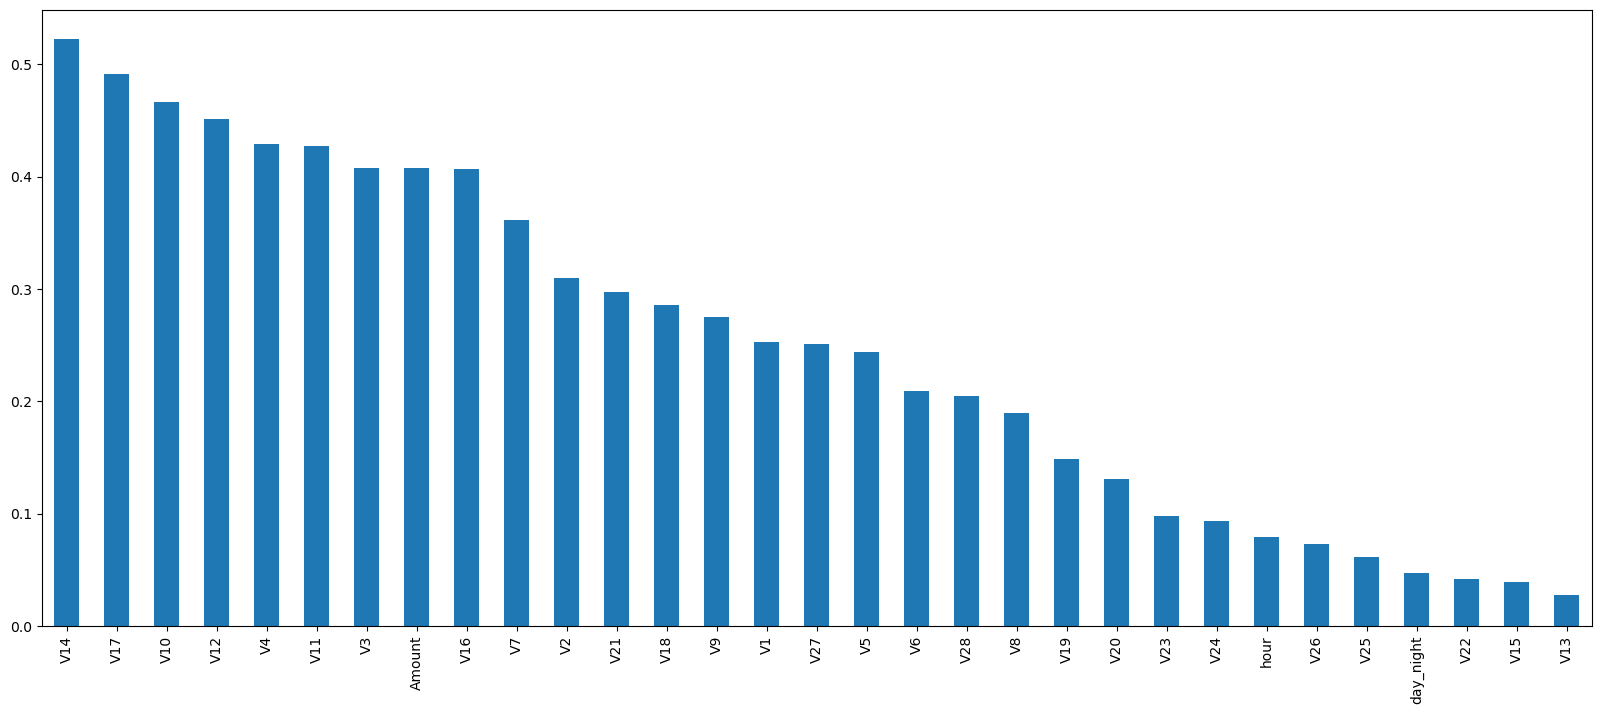

In [36]:
# Plot
mutual_info.sort_values(ascending = False).plot.bar(figsize =(20,8))

In [37]:
# Select the best features
best = mutual_info.index[0:14].to_list()

# Preview
best

['V14',
 'V17',
 'V10',
 'V12',
 'V4',
 'V11',
 'V3',
 'Amount',
 'V16',
 'V7',
 'V2',
 'V21',
 'V18',
 'V9']

> **I varied the number of features selected and ran the model. I saw that choosing around 14 features gave me the highest model accuracy.**

In [38]:
# Filtering features
X_train = X_train[best]

X_test = X_test[best]

X_train.head()

,V14,V17,V10,V12,V4,V11,V3,Amount,V16,V7,V2,V21,V18,V9
0,-0.144569,0.146013,0.730698,0.957722,0.633288,1.228622,1.059268,168.00,-1.598477,-1.010111,-1.124481,-0.031302,1.154906,-0.638138
1,-0.105314,0.615302,0.568833,-0.350313,-0.643636,0.332762,0.691834,2.56,0.847468,-0.625350,-0.450267,-0.050096,-2.136965,-0.799919
2,-1.301226,1.015402,-0.752878,-0.382358,0.627629,-0.350391,-0.948369,0.76,0.507124,0.308920,0.579341,-0.182492,0.101700,-0.099771
3,0.152396,-0.188199,0.680465,-0.182045,-1.623007,-0.504286,-1.501571,11.00,-1.472787,-0.795350,-0.712240,-0.499511,1.034679,-0.938332
4,-3.181877,-3.880118,-1.100876,-3.629825,2.002872,1.551426,-0.798165,15.22,-3.147555,-1.931457,1.117713,0.054897,-2.077592,-0.536328


<Axes: >

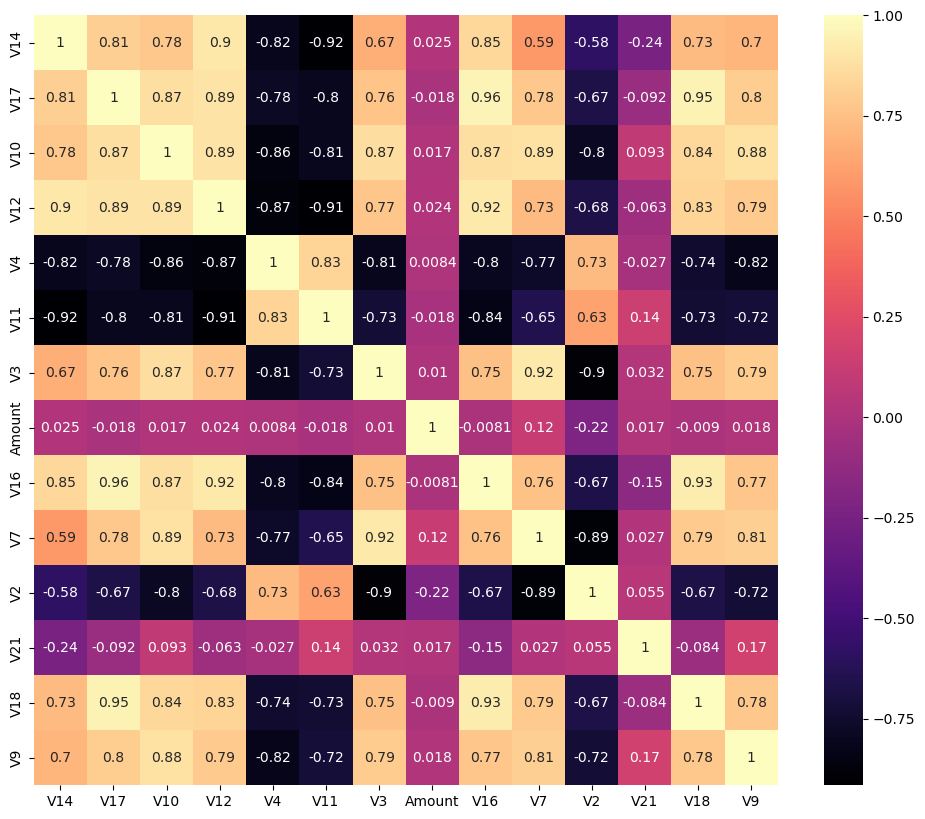

In [39]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(),annot=True,cmap='magma')

## Modelling

We will be first testing multiple classifier models to compare.

#### Performance Metrics

For fraud classification, the decision to prioritise precision or recall is case dependant. If we want to make sure to accurately find every fraud transactions at the expense of potential increase in false positives, we use recall. Or, if we want to make sure the transactions predicted as fraud are correct, we choose precision. In our case, precision is more apt.

I choose **Average precision** and **Top Precision @k** where k=100 as my evaluation metric along with **ROC AUC Score** .

Top precision @ k assesses the proportion of correct or relevant items among the top k predictions or recommendations provided by the system. For credit fraud, the fraud investigators can only look at a finite number of fraud transactions daily. Let's say in our case it is 100. So we need to rank our predicted fraud transactions and make sure to maximise the precision for the top 100 transactions.

Average precision is a metric commonly used in information retrieval tasks, such as ranking and recommendation systems. It takes into account both precision and recall to evaluate the quality of a ranked list of items. Average precision is calculated by computing the precision at each position of the ranked list and then averaging those precision values.

In [40]:
def precision_at_k(y_test, y_test_pred) -> float:
    """
    Function to compute precision@k for an input boolean dataframe
    
    Inputs:
        k      -> integer number of items to consider
        y_test -> string name of column containing actual user input
        y_test_pred -> string name of column containing recommendation output
        
    Output:
        Floating-point number of precision value for k items
    """
    # No of items to consider
    k=100
    
    # Combine actual and predicted to dataframe
    df = pd.DataFrame(dict(y_test = y_test, y_test_pred = y_test_pred)).reset_index(drop=True)
    
    # Sort by predicted
    df = df.sort_values(by='y_test_pred',ascending=False)

    # Convert to boolean
    threshold = 1
    df = df >= threshold
    
    
    
    # Check we have a valid entry for k
    if k <= 0:
        raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
        
    # Extract the k rows
    dfK = df.head(k)
    
    # Compute number of recommended items @k
    denominator = dfK['y_test_pred'].sum()
    
    # Compute number of recommended items that are relevant @k
    numerator = dfK[dfK['y_test_pred'] & dfK['y_test']].shape[0]
    
    # Return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None
    
def recall_at_k(y_test, y_test_pred) -> float:
    """
    Function to compute recall@k for an input boolean dataframe
    
    Inputs:
        k      -> integer number of items to consider
        y_test -> string name of column containing actual user input
        y_test_pred -> string name of column containing recommendation output
        
    Output:
        Floating-point number of recall value for k items
    """
    # No of items to consider
    k=100
    
    # Combine actual and predicted to dataframe
    df = pd.DataFrame(dict(y_test = y_test, y_test_pred = y_test_pred)).reset_index(drop=True)
    
    # Sort by predicted
    df = df.sort_values(by='y_test_pred',ascending=False)

    # Convert to boolean
    threshold = 1
    df = df >= threshold
    
    # Check we have a valid entry for k
    if k <= 0:
        raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
        
    # Extract the k rows
    dfK = df.head(k)
    
    # Compute number of all relevant items
    denominator = df['y_test'].sum()
    
    # Compute number of recommended items that are relevant @k
    numerator = dfK[dfK['y_test_pred'] & dfK['y_test']].shape[0]
    
    # Return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None

In [41]:
# List of models to compare
models = {
    'Random Forest':RandomForestClassifier(random_state=43),
    'Logistic Regression':LogisticRegression(max_iter=100000, random_state=43),
    'Decision Tree':DecisionTreeClassifier(random_state=43),
    'K-nearest Neighbhour':KNeighborsClassifier(),
    'XGBoost':XGBClassifier(random_state=43)
}

score = {}
train_score = []
train_avg_pr= []
test_avg_pr= []
train_topk= []
test_topk =[]

In [42]:
# # List of models to compare
# models = {
#     'Random Forest':RandomForestClassifier(random_state=43)
# }

# score = {}
# train_score = []
# train_avg_pr= []
# test_avg_pr= []
# train_topk= []
# test_topk =[]

In [43]:
for i in range(len(list(models))):
    
    #Select model
    model = list(models.values())[i]
    
    # Train model
    model.fit(X_train,y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    
    print('Model performance for training set \n')
    
    print(f" Training performance of {list(models.keys())[i]}: \n",classification_report(y_train, y_train_pred))
    
    print('Model performance for testing set \n')
    
    print(f" Testing performance of {list(models.keys())[i]}: \n",classification_report(y_test, y_test_pred))
    
    print("Training average precision :",round(average_precision_score(y_train, y_train_pred),2))

    print("Testing average precision  :",round(average_precision_score(y_test, y_test_pred),2))
    
    # No of items to consider
    k=100
    
    print('Train Precision@k: {:.2f}, Train Recall@k: {:.2f} for k={}'.format(precision_at_k(y_train,y_train_pred),recall_at_k(y_train,y_train_pred),k))
    
    # Store train precision @k to list
    train_topk.append(round(precision_at_k(y_train,y_train_pred),2))
    
    print('Test Precision@k: {:.2f}, Test Recall@k: {:.2f} for k={}'.format(precision_at_k(y_test,y_test_pred),recall_at_k(y_test,y_test_pred),k))
    
    # Store test precision @k to list
    test_topk.append(round(precision_at_k(y_test,y_test_pred),2))                 

    print("ROC-AUC score:",round(roc_auc_score(y_test,y_test_pred),3))
    
    print('='*35)
    
    # Store test score in dictionary
    score[list(models.keys())[i]] = round(classification_report(y_test, y_test_pred,output_dict=True)['macro avg']['precision'],2)
    
    # Get train score
    train_score.append(round(classification_report(y_train, y_train_pred,output_dict=True)['macro avg']['precision'],2))
    
    # Get average train precision
    train_avg_pr.append(round(average_precision_score(y_train, y_train_pred),2))
    
    # Get average test precision
    test_avg_pr.append(round(average_precision_score(y_test, y_test_pred),2))

Model performance for training set 

 Training performance of Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    150270
           1       1.00      1.00      1.00    150270

    accuracy                           1.00    300540
   macro avg       1.00      1.00      1.00    300540
weighted avg       1.00      1.00      1.00    300540

Model performance for testing set 

 Testing performance of Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     73651
           1       0.95      0.77      0.85        98

    accuracy                           1.00     73749
   macro avg       0.97      0.88      0.92     73749
weighted avg       1.00      1.00      1.00     73749

Training average precision : 1.0
Testing average precision  : 0.73
Train Precision@k: 1.00, Train Recall@k: 0.00 for k=100
Test Precision@k: 0.95, Test Recall@k: 0.77 for k=100
ROC-AUC score

In [44]:
# Convert metrics to dataframe
m_acc = pd.DataFrame(score.items(),columns = ['model','test_precision'])

# Append list to column
m_acc['train_precision'] = train_score

m_acc['train_top_precision@100'] = train_topk

m_acc['test_top_precision@100'] = test_topk

m_acc['train_average_precision'] = train_avg_pr

m_acc['test_average_precision'] = test_avg_pr

# Preview
m_acc.sort_values('test_top_precision@100',ascending=False)

,model,test_precision,train_precision,train_top_precision@100,test_top_precision@100,train_average_precision,test_average_precision
0,Random Forest,0.97,1.00,1.0,0.95,1.00,0.73
4,XGBoost,0.86,1.00,1.0,0.73,1.00,0.55
2,Decision Tree,0.63,1.00,1.0,0.28,1.00,0.19
3,K-nearest Neighbhour,0.58,1.00,1.0,0.20,1.00,0.13
1,Logistic Regression,0.54,0.96,1.0,0.08,0.95,0.07


Random Forest performed the best on all metrics with a ROC-AUC score of 0.88.

### Hyperparameter Tuning

In [45]:
# Creating custom scorer for precision top k
custom_scorer_object = make_scorer(precision_at_k, greater_is_better=True)

In [46]:
# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)

In [47]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [48]:
# # RF Classifier
# rf = RandomForestClassifier()

# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_grid, 
#                                    n_iter=10, 
#                                    scoring=custom_scorer_object,
#                                    cv=skf,
#                                    verbose=2, 
#                                    random_state=43)

# random_search.fit(X_train, y_train)

In [49]:
# best_params = random_search.best_params_

# print("Best Hyperparameters:", random_search.best_params_)
# print("Best Score:", random_search.best_score_)

In [50]:
# # Save best hyperparameters to json
# with open(PROCESSED + r'rf_best_params.json', 'w') as fp:
#     json.dump(random_search.best_params_, fp)

In [51]:
# Load json
with open(PROCESSED + r'rf_best_params.json', 'r') as fp:
    best_params = json.load(fp)

In [52]:
# Best parameters
best_params

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': None,
 'bootstrap': True}

In [53]:
best_rf = RandomForestClassifier(**best_params, random_state=43)
best_rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, random_state=43)

In [54]:
# Make predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print(f" Training performance of Logistic Regression: \n",classification_report(y_train, y_train_pred))

print(f" Testing performance of Logistic Regression: \n",classification_report(y_test, y_test_pred))

 Training performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    150270
           1       1.00      1.00      1.00    150270

    accuracy                           1.00    300540
   macro avg       1.00      1.00      1.00    300540
weighted avg       1.00      1.00      1.00    300540

 Testing performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     73651
           1       0.91      0.77      0.83        98

    accuracy                           1.00     73749
   macro avg       0.96      0.88      0.92     73749
weighted avg       1.00      1.00      1.00     73749



In [55]:
print('Train Precision@k: {:.2f}, Train Recall@k: {:.2f} for k={}'.format(precision_at_k(y_train,y_train_pred),recall_at_k(y_train,y_train_pred),k))

print('Test Precision@k: {:.2f}, Test Recall@k: {:.2f} for k={}'.format(precision_at_k(y_test,y_test_pred),recall_at_k(y_test,y_test_pred),k))
    
print("Training average precision :",round(average_precision_score(y_train, y_train_pred),2))

print("Testing average precision  :",round(average_precision_score(y_test, y_test_pred),2))
 
print("ROC-AUC score:",round(roc_auc_score(y_test,y_test_pred),3))

Train Precision@k: 1.00, Train Recall@k: 0.00 for k=100
Test Precision@k: 0.91, Test Recall@k: 0.77 for k=100
Training average precision : 1.0
Testing average precision  : 0.7
ROC-AUC score: 0.883


Out of the top 100 predictions, 91% of the predictions labelled as fraudulent were accurate.

An average precision (AP) value of 0.7 indicates that the model achieved a precision of 70% on average across different positions in the ranked list.

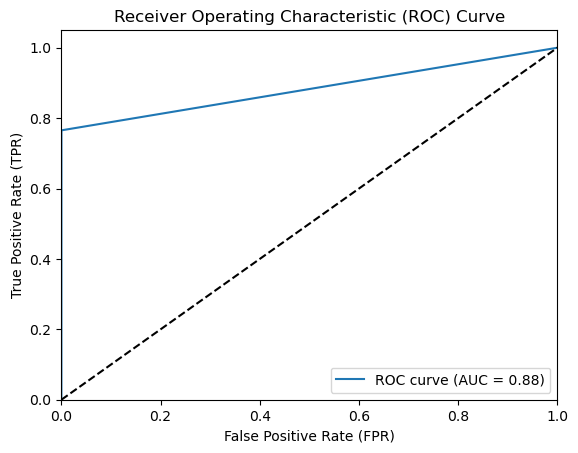

In [56]:
# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

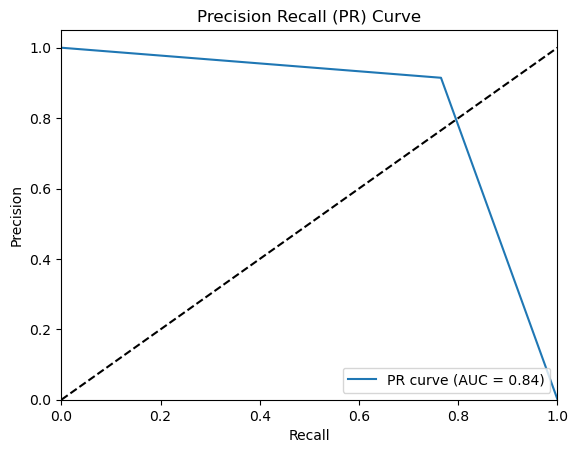

In [57]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)

# Compute the area under the PR curve (AUC)
pr = auc(recall, precision)

# Plot the ROC curve
plt.plot(recall, precision, label='PR curve (AUC = %0.2f)' % pr)
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall (PR) Curve')
plt.legend(loc="lower right")
plt.show()

## Export model

In [58]:
# Model filename
filename = r'rf_model.pickle'

In [59]:
# Export file
pk.dump(best_rf, open(EXPORT+filename, 'wb'))